In [1]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch as t

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
# pretrained_model = GPT2LMHeadModel.from_pretrained("gpt2")

In [2]:
# # Make sure we're using a NVIDIA GPU
# if t.cuda.is_available():
#   gpu_info = !nvidia-smi
#   gpu_info = '\n'.join(gpu_info)
#   if gpu_info.find("failed") >= 0:
#     print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

#   # Get GPU name
#   gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
#   gpu_name = gpu_name[1]
#   GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
#   print(f'GPU name: {GPU_NAME}')

#   # Get GPU capability score
#   GPU_SCORE = t.cuda.get_device_capability()
#   print(f"GPU capability score: {GPU_SCORE}")
#   if GPU_SCORE >= (8, 0):
#     print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
#   else:
#     print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")
  
#   # Print GPU info
#   print(f"GPU information:\n{gpu_info}")

# else:
#   print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

In [3]:
from datasets import load_dataset
ds = load_dataset('stas/openwebtext-10k')
dataset = ds['train']['text']

Found cached dataset openwebtext-10k (/home/ubuntu/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
# pretrained_model.to(device)

In [5]:
def init_layer(layer: t.nn.Module):
    if isinstance(layer, t.nn.Embedding) or isinstance(layer, t.nn.Linear):
        layer.weight.data.normal_(0, 0.02)

In [6]:
class GPTBlock(t.nn.Module):
    def __init__(self, hidden_size = 768, context_length = 1024, dim_size = 3072, p_dropout = 0.1, n_heads = 12):
        super().__init__()
        self.ln_init = t.nn.LayerNorm(hidden_size)
        self.attn = t.nn.MultiheadAttention(hidden_size, n_heads, p_dropout, batch_first = True)
        mask = (t.triu(t.ones(context_length, context_length)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        self.attn_mask = t.nn.Parameter(mask, requires_grad = False)
        self.ln_intermediate = t.nn.LayerNorm(hidden_size)
        self.nn1 = t.nn.Linear(hidden_size, dim_size)
        self.nn2 = t.nn.Linear(dim_size, hidden_size)
        self.gelu = t.nn.GELU()
        self.dropout = t.nn.Dropout(p_dropout)
    
    def forward(self, x):
        resid_0 = x
        x = self.ln_init(x)
        x, _ = self.attn(x, x, x, attn_mask = self.attn_mask, need_weights = False)
        x = self.ln_intermediate(x + resid_0)
        resid_1 = x
        x = self.nn1(x)
        x = self.nn2(x)
        x = self.gelu(x)
        return self.dropout(x + resid_1)

In [7]:
class SimpleGPT2(t.nn.Module):
    def __init__(self, n_blocks = 1, vocab_size = 50257, context_length = 1024, hidden_size = 768, p_dropout = 0.1):
        super().__init__()
        self.wte = t.nn.Embedding(vocab_size, hidden_size)
        self.wpe = t.nn.Embedding(context_length, hidden_size)
        self.pe_matrix = t.nn.Parameter(t.arange(0, context_length).unsqueeze(0), requires_grad = False)
        self.dropout = t.nn.Dropout(p_dropout)
        self.gpt_blocks = t.nn.ModuleList([GPTBlock() for _ in range(n_blocks)])
        self.layernorm = t.nn.LayerNorm(hidden_size)
        self.final = t.nn.Linear(hidden_size, vocab_size)

        for layer in [self.wte, self.wpe, self.final]:
            init_layer(layer)
    
    def forward(self, input_ids: t.Tensor, attention_mask = t.Tensor):
        x = input_ids
        n, seq_len = x.shape
        hidden = self.wte(x) + self.wpe(self.pe_matrix.expand(n, -1))
        hidden = self.dropout(hidden)
        for gpt_block in self.gpt_blocks:
            hidden = gpt_block(hidden)
        hidden = self.layernorm(hidden)
        return self.final(hidden)

In [8]:
# Load the model state_dict.

# model_state_dict = t.load('simpleGPT_30epochs_t2.pt')
simpleGPT2 = SimpleGPT2(n_blocks = 6)
simpleGPT2 = t.compile(simpleGPT2, mode="max-autotune")
# simpleGPT2.load_state_dict(model_state_dict)

In [9]:
#simpleGPT2 = SimpleGPT2(n_blocks = 6)

simpleGPT2.to(device)


# Run model on a few truncated samples ... works!

encoded_input = tokenizer(dataset[0:1], return_tensors='pt', padding='max_length', truncation=True).to(device)
print(encoded_input['attention_mask'].shape, encoded_input['attention_mask'].sum())
logits = simpleGPT2(**encoded_input)
print(logits.shape)

torch.Size([1, 1024]) tensor(1024, device='cuda:0')


[2023-08-01 07:36:41,370] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


torch.Size([1, 1024, 50257])


In [10]:
# How many parameters?
print(sum((p.numel() if p.requires_grad else 0 for p in simpleGPT2.parameters())))

120560209


In [11]:
encoded_input_alt = tokenizer(dataset[0][:100], return_tensors='pt', padding='max_length', truncation=True).to(device)
print(encoded_input_alt['attention_mask'].shape, encoded_input_alt['attention_mask'].sum())

torch.Size([1, 1024]) tensor(21, device='cuda:0')


In [12]:
def greedy_sampling(logits):
  return logits.argmax()

def test_model(model, text = "Replace me by any text you'd like.", steps = 100, sampling = greedy_sampling, is_hf = False):
    eos_token = "<|endoftext|>"
    prompt = text
    print("Starting prompt: " + prompt)

    for i in range(steps):
        encoded_input = tokenizer([prompt], return_tensors="pt", padding='max_length').to(device)
        last_input_idx = encoded_input['attention_mask'][0].sum() - 1
        if is_hf:
            logits = model(**encoded_input).logits[0, last_input_idx]
        else:
            logits = model(**encoded_input)[0, last_input_idx]
        next_token = sampling(logits)
        next_string = tokenizer.decode(next_token)
        if next_string == eos_token:
            break
        prompt = prompt + next_string
    print("Current generation: " + prompt)

In [13]:
def top_k_sampling(k):


      def top_sampling(logits):
          probs = t.nn.functional.softmax(logits)
          values, indices = t.topk(probs, k)
          index = values.multinomial(num_samples = 1, replacement = True)
          return indices[index]
      
      return top_sampling

# Our model generates English, but not really coherent generations.
# test_model(simpleGPT2, text = "Mary is the greatest. Or is she?", steps = 100, sampling = top_k_sampling(100))
# test_model(pretrained_model, text = "Mary is the greatest. Or is she?", is_hf = True, steps = 100, sampling = top_k_sampling(100))

In [ ]:
# test_model(simpleGPT2, text = "Mary is the greatest. Or is she?", steps = 100, sampling = top_k_sampling(100))

In [14]:
def loss_fn(logits, encoded_input):
    # logits: n x seq x d
    # true_tokens: n x seq
    # attention_mask = n x seq
    true_tokens = encoded_input['input_ids']
    attention_mask = encoded_input['attention_mask']
    valid_samples_mask = attention_mask[:, 1:].reshape(-1).bool()
    n, seq, d  = logits.shape
    return t.nn.functional.cross_entropy(logits[:, :-1, :].reshape(-1, d)[valid_samples_mask, :], true_tokens[:, 1:].flatten()[valid_samples_mask]), valid_samples_mask.sum()

def compute_dataset_loss(dataset, model, tokenizer, batch_size = 2):
    loss = 0
    samples = 0
    with t.no_grad():
      n = len(dataset)
      batches = n // batch_size
      for i in range(batches):
          # print(i, batch_size, loss, samples)
          batch = dataset[i:i+batch_size]
          encoded_input = tokenizer(batch, return_tensors='pt', padding='max_length', truncation=True).to(device)
          logits = model(**encoded_input)
          # Find true labels and compute loss
          ce_loss, valid_samples = loss_fn(logits, encoded_input)
          loss = (loss * samples + ce_loss * valid_samples ) / (samples + valid_samples)
          samples = samples + valid_samples
    return loss, samples

# Compute loss of the pre-trained model on the truncated dataset
# print(compute_dataset_loss(dataset[:100], simpleGPT2, tokenizer))

# Notes: Initial loss is 4.7, same as last time.

In [15]:
def compute_val_dataset_loss(dataset, model, tokenizer, val_frac = 0.2):
    n = len(dataset)
    val_size = int(n * val_frac)
    return compute_dataset_loss(dataset[-val_size:], model, tokenizer)
  
# Compute validation loss
# print(compute_val_dataset_loss(dataset, 0.1))

Starting epoch:  0
0 0.0 2 0 0
Current GPU memory usage: 1655.937536 MB


[2023-08-01 07:37:34,910] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-08-01 07:37:47,484] torch._inductor.utils: [WARNING] skipping cudagraphs due to complex input striding


200 0.05 2 tensor(9.3619, device='cuda:0', grad_fn=<DivBackward0>) tensor(285125, device='cuda:0')
Current GPU memory usage: 5402.875904 MB
400 0.1 2 tensor(8.8125, device='cuda:0', grad_fn=<DivBackward0>) tensor(563845, device='cuda:0')
Current GPU memory usage: 5403.183104 MB
600 0.15 2 tensor(8.4602, device='cuda:0', grad_fn=<DivBackward0>) tensor(853621, device='cuda:0')
Current GPU memory usage: 5403.490304 MB
800 0.2 2 tensor(8.2273, device='cuda:0', grad_fn=<DivBackward0>) tensor(1134009, device='cuda:0')
Current GPU memory usage: 5403.797504 MB
1000 0.25 2 tensor(8.0689, device='cuda:0', grad_fn=<DivBackward0>) tensor(1406417, device='cuda:0')
Current GPU memory usage: 5404.104704 MB
1200 0.3 2 tensor(7.9288, device='cuda:0', grad_fn=<DivBackward0>) tensor(1686957, device='cuda:0')
Current GPU memory usage: 5404.411904 MB
1400 0.35 2 tensor(7.8278, device='cuda:0', grad_fn=<DivBackward0>) tensor(1958751, device='cuda:0')
Current GPU memory usage: 5404.719104 MB
1600 0.4 2 tenso

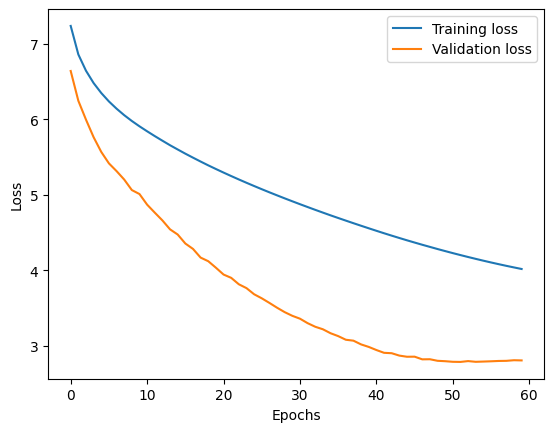

(tensor(4.0168, device='cuda:0', grad_fn=<DivBackward0>), tensor(334194732, device='cuda:0'))


In [16]:
# Fine-tune the model on a subset of training set, and then evaluate on val set
#TODO Separate this code into two parts. Calculate batch time as well. Save epoch run files
import random
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from torch._inductor import config

import time
import matplotlib.pyplot as plt

def train_model(dataset, optimizer, epochs, model, tokenizer, batch_size = 2):
    loss = 0
    samples = 0
    n = len(dataset)
    batches = n // batch_size
    print_interval = batches // 20
    losses = []  # Store loss for each epoch
    val_losses = [] # Store validation loss for each epoch

    scheduler = OneCycleLR(optimizer, max_lr = 2.5e-4, total_steps = epochs * batches, pct_start = 0.2)

    for epoch in range(epochs):
        start_time = time.time()
        random.shuffle(dataset)
        print("Starting epoch: ", epoch)
        for i in range(batches):
            if i % print_interval == 0:
                print(i, i/float(batches), batch_size, loss, samples)
                print(f"Current GPU memory usage: {t.cuda.memory_allocated() / 1e6} MB")

            optimizer.zero_grad()

            batch = dataset[i:i+batch_size]
            encoded_input = tokenizer(batch, return_tensors='pt', padding='max_length', truncation=True).to(device)
            logits = model(**encoded_input)

            # Find true labels and compute loss
            ce_loss, valid_samples = loss_fn(logits, encoded_input)
            loss = (loss * samples + ce_loss * valid_samples ) / (samples + valid_samples)
            samples = samples + valid_samples

            # Backprop
            ce_loss.backward()
            optimizer.step()
            scheduler.step()

        end_time = time.time()
        epoch_time = end_time - start_time

        losses.append(loss.item())

        val_loss, _ = compute_dataset_loss(dataset, model, tokenizer, batch_size=batch_size)
        val_losses.append(val_loss.item())

        if (epoch + 1) % 5 == 0:
            checkpoint_filename = f'simpleGPT_{epoch + 1}epochs_t2_batch2.pt'
            t.save(model.state_dict(), checkpoint_filename)
            print(f"Saved model checkpoint to {checkpoint_filename}")
        
        # print(f"Epoch {epoch} finished in {epoch_time} seconds with loss {loss.item()}")
        print(f"Epoch {epoch} finished in {epoch_time} seconds with loss {loss.item()} and val_loss {val_loss}")

    # Plot loss over epochs
    plt.plot(range(epochs), losses, label='Training loss')
    plt.plot(range(epochs), val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return loss, samples


epochs = 60

lrs = [5e-5, 5e-4, 1e-5, 2e-5]

# config.compile_threads = 1
# simpleGPT2 = t.compile(simpleGPT2, mode="max-autotune")

optimizer = Adam(simpleGPT2.parameters(), lr = lrs[-1])

print(train_model(dataset[:2000*4], optimizer, epochs, simpleGPT2, tokenizer))

In [ ]:
t.save(simpleGPT2.state_dict(), 'simpleGPT_60epochs_t2_batch2.pt')